# Whale Detection Challenge : NN_model

Method overview : FFT to convert the sound tracks into spectrograms, and apply distinct preprocessing methods such as clipping, noise removal, PCEN and filters. After preprocessing we feed the spectrograms into state of the art light CNN models such as Resnet 18, VGG 16 or GoogleNet to identify right whale call patterns and perform classification. We may also try the removal of pooling layers in the networks and see if it causes better outcome.

In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import cv2
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.3.1
Torchvision Version:  0.4.2


## Import and Load Data

In [2]:
num_classes = 2
batch_size = 32
num_epochs = 200
feature_extract = True
groups = 3
vis_batch = 4

In [3]:
data_dir = "data/"
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x+"_prep_10/"), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=8) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


## Model

In [11]:
# The nn CNN model
class nn_model(nn.Module):
    # input size 40*500
    # image = cv2.resize(image, (40, 500), interpolation = cv2.INTER_CUBIC)

    def __init__(self):
        super(nn_model, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7, stride=1, padding=(3, 3), bias=False),
            nn.BatchNorm2d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(8, 8, kernel_size=7, stride=1, padding=(3, 3), bias=False),
            nn.BatchNorm2d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(8, 8, kernel_size=7, stride=1, padding=(3, 3), bias=False),
            nn.BatchNorm2d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=(2, 2), bias=False),
            nn.BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=5, stride=1, padding=(2, 2), bias=False),
            nn.BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=5, stride=1, padding=(2, 2), bias=False),
            nn.BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=(1, 1), bias=False),
            nn.BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=(1, 1), bias=False),
            nn.BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=(1, 1), bias=False),
            nn.BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
        )    
        self.decoder = nn.Sequential(             
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=(1, 1), bias=False),
            nn.BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=(1, 1), bias=False),
            nn.BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=(1, 1), bias=False),
            nn.BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),
            nn.ConvTranspose2d(16, 16, kernel_size=5, stride=1, padding=(2, 2), bias=False),
            nn.BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 16, kernel_size=5, stride=1, padding=(2, 2), bias=False),
            nn.BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=5, stride=1, padding=(2, 2), bias=False),
            nn.BatchNorm2d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),
            nn.ConvTranspose2d(8, 8, kernel_size=7, stride=1, padding=(3, 3), bias=False),
            nn.BatchNorm2d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 8, kernel_size=7, stride=1, padding=(3, 3), bias=False),
            nn.BatchNorm2d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, kernel_size=7, stride=1, padding=(3, 3), bias=False),
            nn.BatchNorm2d(3, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(  
            nn.Flatten(),
            nn.Linear(2048, 2048),
            nn.BatchNorm1d(2048, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Linear(1024, 2),
            nn.BatchNorm1d(2, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
        )
    def forward(self, x):
        x_code = self.encoder(x)
        x_class = self.classifier(x_code)
#         x_recover = self.decoder(x_code)      
        return x_class, x_recover #classification and recover vectors of 



In [12]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = small_model()
#     num_ftrs = model_ft.fc3.out_features
#     model_ft.fc4 = nn.Linear(num_ftrs, num_classes)
    input_size = (64, 64)  
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

small_model(
  (conv1): Conv2d(3, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (dropout): Dropout2d(p=0.3, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv3): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (conv5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (flat): Flatten()
  (fc1): Linear(in_features=2048, out_featu

## Training Section

### training fuction

In [13]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()
    history = {'train_loss':[],'train_acc':[],'val_loss':[],'val_acc':[]}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc)
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history, best_acc

### optimizer

In [14]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9, weight_decay=0.01)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 conv2.weight
	 conv3.weight
	 bn2.weight
	 bn2.bias
	 conv4.weight
	 conv5.weight
	 bn3.weight
	 bn3.bias
	 conv6.weight
	 fc1.weight
	 fc1.bias
	 bn4.weight
	 bn4.bias
	 fc2.weight
	 fc2.bias
	 bn5.weight
	 bn5.bias
	 fc3.weight
	 fc3.bias
	 bn6.weight
	 bn6.bias
	 fc4.weight
	 fc4.bias
	 bn7.weight
	 bn7.bias


### run and save model

In [15]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist, best_acc = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)
torch.save(model_ft.state_dict(), 'model_weight/NN_model_'+str(num_epochs))
print(model_ft.state_dict().keys())

Epoch 0/199
----------
train Loss: 0.6115 Acc: 0.7287
val Loss: 0.4794 Acc: 0.7663

Epoch 1/199
----------
train Loss: 0.4704 Acc: 0.8527
val Loss: 0.4249 Acc: 0.7920

Epoch 2/199
----------
train Loss: 0.4132 Acc: 0.8683
val Loss: 0.4095 Acc: 0.8270

Epoch 3/199
----------
train Loss: 0.3848 Acc: 0.8727
val Loss: 0.4167 Acc: 0.7847

Epoch 4/199
----------
train Loss: 0.3599 Acc: 0.8793
val Loss: 0.3567 Acc: 0.8723

Epoch 5/199
----------
train Loss: 0.3487 Acc: 0.8827
val Loss: 0.3918 Acc: 0.8180

Epoch 6/199
----------
train Loss: 0.3267 Acc: 0.8843
val Loss: 0.3329 Acc: 0.8777

Epoch 7/199
----------
train Loss: 0.3245 Acc: 0.8827
val Loss: 0.3145 Acc: 0.8833

Epoch 8/199
----------
train Loss: 0.3106 Acc: 0.8867
val Loss: 0.3231 Acc: 0.8743

Epoch 9/199
----------
train Loss: 0.2999 Acc: 0.8907
val Loss: 0.3286 Acc: 0.8663

Epoch 10/199
----------
train Loss: 0.2925 Acc: 0.8893
val Loss: 0.3290 Acc: 0.8610

Epoch 11/199
----------
train Loss: 0.2838 Acc: 0.8953
val Loss: 0.3913 Acc

val Loss: 0.3518 Acc: 0.8813

Epoch 97/199
----------
train Loss: 0.0484 Acc: 0.9977
val Loss: 0.3122 Acc: 0.8763

Epoch 98/199
----------
train Loss: 0.0451 Acc: 0.9983
val Loss: 0.3130 Acc: 0.8803

Epoch 99/199
----------
train Loss: 0.0499 Acc: 0.9970
val Loss: 0.2901 Acc: 0.8900

Epoch 100/199
----------
train Loss: 0.0510 Acc: 0.9970
val Loss: 0.3137 Acc: 0.8737

Epoch 101/199
----------
train Loss: 0.0466 Acc: 0.9977
val Loss: 0.3469 Acc: 0.8483

Epoch 102/199
----------
train Loss: 0.0465 Acc: 0.9980
val Loss: 0.2932 Acc: 0.8733

Epoch 103/199
----------
train Loss: 0.0514 Acc: 0.9960
val Loss: 0.2999 Acc: 0.8823

Epoch 104/199
----------
train Loss: 0.0551 Acc: 0.9960
val Loss: 0.4334 Acc: 0.8427

Epoch 105/199
----------
train Loss: 0.0473 Acc: 0.9980
val Loss: 0.3324 Acc: 0.8837

Epoch 106/199
----------
train Loss: 0.0472 Acc: 0.9983
val Loss: 0.4556 Acc: 0.8383

Epoch 107/199
----------
train Loss: 0.0476 Acc: 0.9977
val Loss: 0.4134 Acc: 0.8690

Epoch 108/199
----------
tr

train Loss: 0.0462 Acc: 0.9973
val Loss: 0.3119 Acc: 0.8767

Epoch 193/199
----------
train Loss: 0.0475 Acc: 0.9970
val Loss: 0.3894 Acc: 0.8463

Epoch 194/199
----------
train Loss: 0.0536 Acc: 0.9933
val Loss: 0.3166 Acc: 0.8743

Epoch 195/199
----------
train Loss: 0.0444 Acc: 0.9987
val Loss: 0.3232 Acc: 0.8710

Epoch 196/199
----------
train Loss: 0.0431 Acc: 0.9993
val Loss: 0.3105 Acc: 0.8743

Epoch 197/199
----------
train Loss: 0.0447 Acc: 0.9990
val Loss: 0.3365 Acc: 0.8610

Epoch 198/199
----------
train Loss: 0.0430 Acc: 0.9990
val Loss: 0.3388 Acc: 0.8597

Epoch 199/199
----------
train Loss: 0.0460 Acc: 0.9977
val Loss: 0.3025 Acc: 0.8747

Training complete in 14m 24s
Best val Acc: 0.895333
odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'conv2.weight', 'conv3.weight', 'bn2.weight', 'bn2.bias', 'bn2.running_mean', 'bn2.running_var', 'bn2.num_batches_tracked', 'conv4.weight', 'conv5.weight', 'bn3.weig

### plot loss and accuracy

dict_keys(['train_loss', 'train_acc', 'val_loss', 'val_acc'])


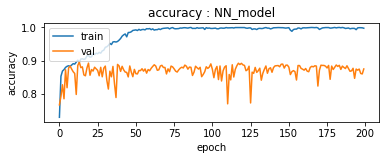

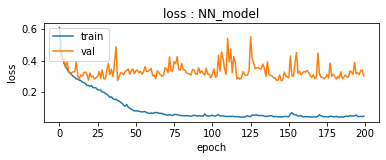

tensor(0.8953, device='cuda:0', dtype=torch.float64)


In [16]:
print(hist.keys())

#### Fill in plot #####
#Plot accuracy vs epoch
plt.subplot(211)

plt.plot(hist['train_acc'])
plt.plot(hist['val_acc'])
plt.title('accuracy : NN_model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Plot loss vs epoch
plt.subplot(212)
plt.plot(hist['train_loss'])
plt.plot(hist['val_loss'])
plt.title('loss : NN_model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

print(best_acc)

### load model and prediction

In [10]:
def forward_vis(vis_loader, groups):
    since = time.time()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    model = models.googlenet(aux_logits=False)
    set_parameter_requires_grad(model, feature_extract)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    # load best model weights
    state_dict = torch.load('model_weight/NN_model_'+str(num_epochs))
    print(state_dict.keys())
    model.load_state_dict(torch.load('model_weight/NN_model_'+str(num_epochs)))
    model.to(device)
    model.eval()   # Set model to evaluate mode
    # Iterate over data.
    cnt=0
    vis_dict = {'inputs':np.empty([groups,vis_batch,3,224,224]),'outputs':np.empty([groups,vis_batch,num_classes]),'labels':np.empty([groups,vis_batch]),'preds':np.empty([groups,vis_batch])}
    for inputs, labels in vis_loader:
            if(cnt==groups):
                break;
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            vis_dict['inputs'][cnt,:,:,:,:]=inputs.cpu().numpy()
            vis_dict['labels'][cnt,:]=labels.cpu().numpy()
            # forward
            # track history if only in train
            with torch.set_grad_enabled(False):
            # Get model outputs and calculate loss
            # Special case for inception because in training it has an auxiliary output. In train
            #   mode we calculate the loss by summing the final output and the auxiliary output
            #   but in testing we only consider the final output.
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                vis_dict['outputs'][cnt,:,:]=outputs.cpu().numpy()
                vis_dict['preds'][cnt,:]=preds.cpu().numpy()
            cnt+=1
            

    time_elapsed = time.time() - since
    print()
    print('Inference complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    return vis_dict

vis_loader = torch.utils.data.DataLoader(image_datasets['val'], batch_size=vis_batch, shuffle=True, num_workers=8)
vis_dict = forward_vis(vis_loader, groups)
print(vis_dict['inputs'].shape)
print(vis_dict['outputs'].shape)
print(vis_dict['labels'].shape)
print(vis_dict['preds'].shape)

cuda:0
odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'conv2.weight', 'conv3.weight', 'bn2.weight', 'bn2.bias', 'bn2.running_mean', 'bn2.running_var', 'bn2.num_batches_tracked', 'conv4.weight', 'conv5.weight', 'bn3.weight', 'bn3.bias', 'bn3.running_mean', 'bn3.running_var', 'bn3.num_batches_tracked', 'conv6.weight', 'fc1.weight', 'fc1.bias', 'bn4.weight', 'bn4.bias', 'bn4.running_mean', 'bn4.running_var', 'bn4.num_batches_tracked', 'fc2.weight', 'fc2.bias', 'bn5.weight', 'bn5.bias', 'bn5.running_mean', 'bn5.running_var', 'bn5.num_batches_tracked', 'fc3.weight', 'fc3.bias', 'bn6.weight', 'bn6.bias', 'bn6.running_mean', 'bn6.running_var', 'bn6.num_batches_tracked', 'fc4.weight', 'fc4.bias', 'bn7.weight', 'bn7.bias', 'bn7.running_mean', 'bn7.running_var', 'bn7.num_batches_tracked'])


RuntimeError: Error(s) in loading state_dict for GoogLeNet:
	Missing key(s) in state_dict: "conv1.conv.weight", "conv1.bn.weight", "conv1.bn.bias", "conv1.bn.running_mean", "conv1.bn.running_var", "conv2.conv.weight", "conv2.bn.weight", "conv2.bn.bias", "conv2.bn.running_mean", "conv2.bn.running_var", "conv3.conv.weight", "conv3.bn.weight", "conv3.bn.bias", "conv3.bn.running_mean", "conv3.bn.running_var", "inception3a.branch1.conv.weight", "inception3a.branch1.bn.weight", "inception3a.branch1.bn.bias", "inception3a.branch1.bn.running_mean", "inception3a.branch1.bn.running_var", "inception3a.branch2.0.conv.weight", "inception3a.branch2.0.bn.weight", "inception3a.branch2.0.bn.bias", "inception3a.branch2.0.bn.running_mean", "inception3a.branch2.0.bn.running_var", "inception3a.branch2.1.conv.weight", "inception3a.branch2.1.bn.weight", "inception3a.branch2.1.bn.bias", "inception3a.branch2.1.bn.running_mean", "inception3a.branch2.1.bn.running_var", "inception3a.branch3.0.conv.weight", "inception3a.branch3.0.bn.weight", "inception3a.branch3.0.bn.bias", "inception3a.branch3.0.bn.running_mean", "inception3a.branch3.0.bn.running_var", "inception3a.branch3.1.conv.weight", "inception3a.branch3.1.bn.weight", "inception3a.branch3.1.bn.bias", "inception3a.branch3.1.bn.running_mean", "inception3a.branch3.1.bn.running_var", "inception3a.branch4.1.conv.weight", "inception3a.branch4.1.bn.weight", "inception3a.branch4.1.bn.bias", "inception3a.branch4.1.bn.running_mean", "inception3a.branch4.1.bn.running_var", "inception3b.branch1.conv.weight", "inception3b.branch1.bn.weight", "inception3b.branch1.bn.bias", "inception3b.branch1.bn.running_mean", "inception3b.branch1.bn.running_var", "inception3b.branch2.0.conv.weight", "inception3b.branch2.0.bn.weight", "inception3b.branch2.0.bn.bias", "inception3b.branch2.0.bn.running_mean", "inception3b.branch2.0.bn.running_var", "inception3b.branch2.1.conv.weight", "inception3b.branch2.1.bn.weight", "inception3b.branch2.1.bn.bias", "inception3b.branch2.1.bn.running_mean", "inception3b.branch2.1.bn.running_var", "inception3b.branch3.0.conv.weight", "inception3b.branch3.0.bn.weight", "inception3b.branch3.0.bn.bias", "inception3b.branch3.0.bn.running_mean", "inception3b.branch3.0.bn.running_var", "inception3b.branch3.1.conv.weight", "inception3b.branch3.1.bn.weight", "inception3b.branch3.1.bn.bias", "inception3b.branch3.1.bn.running_mean", "inception3b.branch3.1.bn.running_var", "inception3b.branch4.1.conv.weight", "inception3b.branch4.1.bn.weight", "inception3b.branch4.1.bn.bias", "inception3b.branch4.1.bn.running_mean", "inception3b.branch4.1.bn.running_var", "inception4a.branch1.conv.weight", "inception4a.branch1.bn.weight", "inception4a.branch1.bn.bias", "inception4a.branch1.bn.running_mean", "inception4a.branch1.bn.running_var", "inception4a.branch2.0.conv.weight", "inception4a.branch2.0.bn.weight", "inception4a.branch2.0.bn.bias", "inception4a.branch2.0.bn.running_mean", "inception4a.branch2.0.bn.running_var", "inception4a.branch2.1.conv.weight", "inception4a.branch2.1.bn.weight", "inception4a.branch2.1.bn.bias", "inception4a.branch2.1.bn.running_mean", "inception4a.branch2.1.bn.running_var", "inception4a.branch3.0.conv.weight", "inception4a.branch3.0.bn.weight", "inception4a.branch3.0.bn.bias", "inception4a.branch3.0.bn.running_mean", "inception4a.branch3.0.bn.running_var", "inception4a.branch3.1.conv.weight", "inception4a.branch3.1.bn.weight", "inception4a.branch3.1.bn.bias", "inception4a.branch3.1.bn.running_mean", "inception4a.branch3.1.bn.running_var", "inception4a.branch4.1.conv.weight", "inception4a.branch4.1.bn.weight", "inception4a.branch4.1.bn.bias", "inception4a.branch4.1.bn.running_mean", "inception4a.branch4.1.bn.running_var", "inception4b.branch1.conv.weight", "inception4b.branch1.bn.weight", "inception4b.branch1.bn.bias", "inception4b.branch1.bn.running_mean", "inception4b.branch1.bn.running_var", "inception4b.branch2.0.conv.weight", "inception4b.branch2.0.bn.weight", "inception4b.branch2.0.bn.bias", "inception4b.branch2.0.bn.running_mean", "inception4b.branch2.0.bn.running_var", "inception4b.branch2.1.conv.weight", "inception4b.branch2.1.bn.weight", "inception4b.branch2.1.bn.bias", "inception4b.branch2.1.bn.running_mean", "inception4b.branch2.1.bn.running_var", "inception4b.branch3.0.conv.weight", "inception4b.branch3.0.bn.weight", "inception4b.branch3.0.bn.bias", "inception4b.branch3.0.bn.running_mean", "inception4b.branch3.0.bn.running_var", "inception4b.branch3.1.conv.weight", "inception4b.branch3.1.bn.weight", "inception4b.branch3.1.bn.bias", "inception4b.branch3.1.bn.running_mean", "inception4b.branch3.1.bn.running_var", "inception4b.branch4.1.conv.weight", "inception4b.branch4.1.bn.weight", "inception4b.branch4.1.bn.bias", "inception4b.branch4.1.bn.running_mean", "inception4b.branch4.1.bn.running_var", "inception4c.branch1.conv.weight", "inception4c.branch1.bn.weight", "inception4c.branch1.bn.bias", "inception4c.branch1.bn.running_mean", "inception4c.branch1.bn.running_var", "inception4c.branch2.0.conv.weight", "inception4c.branch2.0.bn.weight", "inception4c.branch2.0.bn.bias", "inception4c.branch2.0.bn.running_mean", "inception4c.branch2.0.bn.running_var", "inception4c.branch2.1.conv.weight", "inception4c.branch2.1.bn.weight", "inception4c.branch2.1.bn.bias", "inception4c.branch2.1.bn.running_mean", "inception4c.branch2.1.bn.running_var", "inception4c.branch3.0.conv.weight", "inception4c.branch3.0.bn.weight", "inception4c.branch3.0.bn.bias", "inception4c.branch3.0.bn.running_mean", "inception4c.branch3.0.bn.running_var", "inception4c.branch3.1.conv.weight", "inception4c.branch3.1.bn.weight", "inception4c.branch3.1.bn.bias", "inception4c.branch3.1.bn.running_mean", "inception4c.branch3.1.bn.running_var", "inception4c.branch4.1.conv.weight", "inception4c.branch4.1.bn.weight", "inception4c.branch4.1.bn.bias", "inception4c.branch4.1.bn.running_mean", "inception4c.branch4.1.bn.running_var", "inception4d.branch1.conv.weight", "inception4d.branch1.bn.weight", "inception4d.branch1.bn.bias", "inception4d.branch1.bn.running_mean", "inception4d.branch1.bn.running_var", "inception4d.branch2.0.conv.weight", "inception4d.branch2.0.bn.weight", "inception4d.branch2.0.bn.bias", "inception4d.branch2.0.bn.running_mean", "inception4d.branch2.0.bn.running_var", "inception4d.branch2.1.conv.weight", "inception4d.branch2.1.bn.weight", "inception4d.branch2.1.bn.bias", "inception4d.branch2.1.bn.running_mean", "inception4d.branch2.1.bn.running_var", "inception4d.branch3.0.conv.weight", "inception4d.branch3.0.bn.weight", "inception4d.branch3.0.bn.bias", "inception4d.branch3.0.bn.running_mean", "inception4d.branch3.0.bn.running_var", "inception4d.branch3.1.conv.weight", "inception4d.branch3.1.bn.weight", "inception4d.branch3.1.bn.bias", "inception4d.branch3.1.bn.running_mean", "inception4d.branch3.1.bn.running_var", "inception4d.branch4.1.conv.weight", "inception4d.branch4.1.bn.weight", "inception4d.branch4.1.bn.bias", "inception4d.branch4.1.bn.running_mean", "inception4d.branch4.1.bn.running_var", "inception4e.branch1.conv.weight", "inception4e.branch1.bn.weight", "inception4e.branch1.bn.bias", "inception4e.branch1.bn.running_mean", "inception4e.branch1.bn.running_var", "inception4e.branch2.0.conv.weight", "inception4e.branch2.0.bn.weight", "inception4e.branch2.0.bn.bias", "inception4e.branch2.0.bn.running_mean", "inception4e.branch2.0.bn.running_var", "inception4e.branch2.1.conv.weight", "inception4e.branch2.1.bn.weight", "inception4e.branch2.1.bn.bias", "inception4e.branch2.1.bn.running_mean", "inception4e.branch2.1.bn.running_var", "inception4e.branch3.0.conv.weight", "inception4e.branch3.0.bn.weight", "inception4e.branch3.0.bn.bias", "inception4e.branch3.0.bn.running_mean", "inception4e.branch3.0.bn.running_var", "inception4e.branch3.1.conv.weight", "inception4e.branch3.1.bn.weight", "inception4e.branch3.1.bn.bias", "inception4e.branch3.1.bn.running_mean", "inception4e.branch3.1.bn.running_var", "inception4e.branch4.1.conv.weight", "inception4e.branch4.1.bn.weight", "inception4e.branch4.1.bn.bias", "inception4e.branch4.1.bn.running_mean", "inception4e.branch4.1.bn.running_var", "inception5a.branch1.conv.weight", "inception5a.branch1.bn.weight", "inception5a.branch1.bn.bias", "inception5a.branch1.bn.running_mean", "inception5a.branch1.bn.running_var", "inception5a.branch2.0.conv.weight", "inception5a.branch2.0.bn.weight", "inception5a.branch2.0.bn.bias", "inception5a.branch2.0.bn.running_mean", "inception5a.branch2.0.bn.running_var", "inception5a.branch2.1.conv.weight", "inception5a.branch2.1.bn.weight", "inception5a.branch2.1.bn.bias", "inception5a.branch2.1.bn.running_mean", "inception5a.branch2.1.bn.running_var", "inception5a.branch3.0.conv.weight", "inception5a.branch3.0.bn.weight", "inception5a.branch3.0.bn.bias", "inception5a.branch3.0.bn.running_mean", "inception5a.branch3.0.bn.running_var", "inception5a.branch3.1.conv.weight", "inception5a.branch3.1.bn.weight", "inception5a.branch3.1.bn.bias", "inception5a.branch3.1.bn.running_mean", "inception5a.branch3.1.bn.running_var", "inception5a.branch4.1.conv.weight", "inception5a.branch4.1.bn.weight", "inception5a.branch4.1.bn.bias", "inception5a.branch4.1.bn.running_mean", "inception5a.branch4.1.bn.running_var", "inception5b.branch1.conv.weight", "inception5b.branch1.bn.weight", "inception5b.branch1.bn.bias", "inception5b.branch1.bn.running_mean", "inception5b.branch1.bn.running_var", "inception5b.branch2.0.conv.weight", "inception5b.branch2.0.bn.weight", "inception5b.branch2.0.bn.bias", "inception5b.branch2.0.bn.running_mean", "inception5b.branch2.0.bn.running_var", "inception5b.branch2.1.conv.weight", "inception5b.branch2.1.bn.weight", "inception5b.branch2.1.bn.bias", "inception5b.branch2.1.bn.running_mean", "inception5b.branch2.1.bn.running_var", "inception5b.branch3.0.conv.weight", "inception5b.branch3.0.bn.weight", "inception5b.branch3.0.bn.bias", "inception5b.branch3.0.bn.running_mean", "inception5b.branch3.0.bn.running_var", "inception5b.branch3.1.conv.weight", "inception5b.branch3.1.bn.weight", "inception5b.branch3.1.bn.bias", "inception5b.branch3.1.bn.running_mean", "inception5b.branch3.1.bn.running_var", "inception5b.branch4.1.conv.weight", "inception5b.branch4.1.bn.weight", "inception5b.branch4.1.bn.bias", "inception5b.branch4.1.bn.running_mean", "inception5b.branch4.1.bn.running_var", "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "bn1.num_batches_tracked", "bn2.weight", "bn2.bias", "bn2.running_mean", "bn2.running_var", "bn2.num_batches_tracked", "conv4.weight", "conv5.weight", "bn3.weight", "bn3.bias", "bn3.running_mean", "bn3.running_var", "bn3.num_batches_tracked", "conv6.weight", "fc1.weight", "fc1.bias", "bn4.weight", "bn4.bias", "bn4.running_mean", "bn4.running_var", "bn4.num_batches_tracked", "fc2.weight", "fc2.bias", "bn5.weight", "bn5.bias", "bn5.running_mean", "bn5.running_var", "bn5.num_batches_tracked", "fc3.weight", "fc3.bias", "bn6.weight", "bn6.bias", "bn6.running_mean", "bn6.running_var", "bn6.num_batches_tracked", "fc4.weight", "fc4.bias", "bn7.weight", "bn7.bias", "bn7.running_mean", "bn7.running_var", "bn7.num_batches_tracked", "conv1.weight", "conv2.weight", "conv3.weight". 

### visualization 

In [ ]:
for i in range(groups) :
    for j in range(vis_batch) :
        plt.figure(figsize=(15,15))
        plt.subplot(groups,vis_batch,4*i+j+1)
        image = np.moveaxis(np.squeeze(vis_dict['inputs'][i,j]), 0, -1)
        image = (image-np.amin(image))/(np.amax(image)-np.amin(image))
        plt.imshow(image)
        plt.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        left=False,         # ticks along the left edge are off
        labelbottom=False,
        labelleft=False) # labels along the bottom edge are off
        plt.title('preprocessed '+str(i)+' '+str(j))
        plt.xlabel('label : '+str(vis_dict['labels'][i,j])+', pred : '+str(vis_dict['preds'][i,j])+', output : '+str(vis_dict['outputs'][i,j,:]))
plt.show()